In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

*** None ***
1
Training LSTM model for Revenue...
Epoch 1/200


C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1653
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1716 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1551 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1501 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1480 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1304 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0975 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0864 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0689 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0616 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0433 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0414 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0417 
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0374 
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0375 
Epoch 16/200
4/4 ━━━━━━━━━━━━━━━

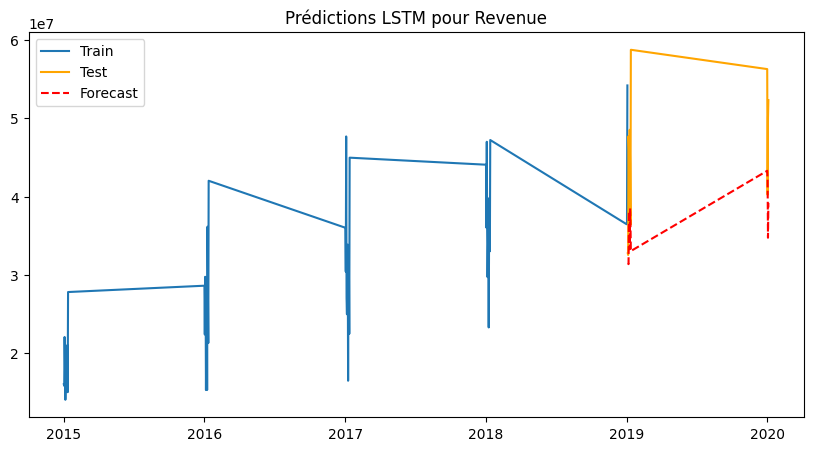

Training LSTM model for Sales_quantity...
Epoch 1/200


C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1409
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1467 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1299 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1118 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1156 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1054 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0796 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0795 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0544 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0549 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0426 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0342 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0396 
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0390 
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0381 
Epoch 16/200
4/4 ━━━━━━━━━━━━━━━

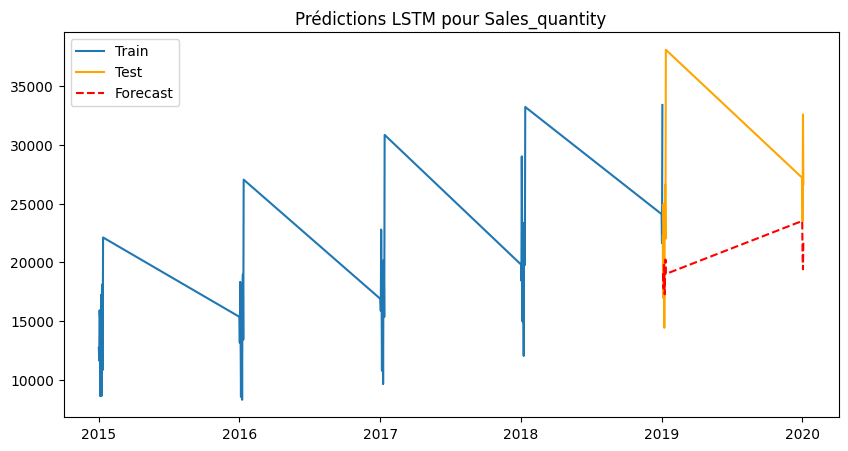

Training LSTM model for Average_cost...
Epoch 1/200


C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1687
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1719 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1497 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1341 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1285 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1009 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1024 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0691 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0677 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0465 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0367 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0338 
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0320 
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0340 
Epoch 16/200
4/4 ━━━━━━━━━━━━━━━

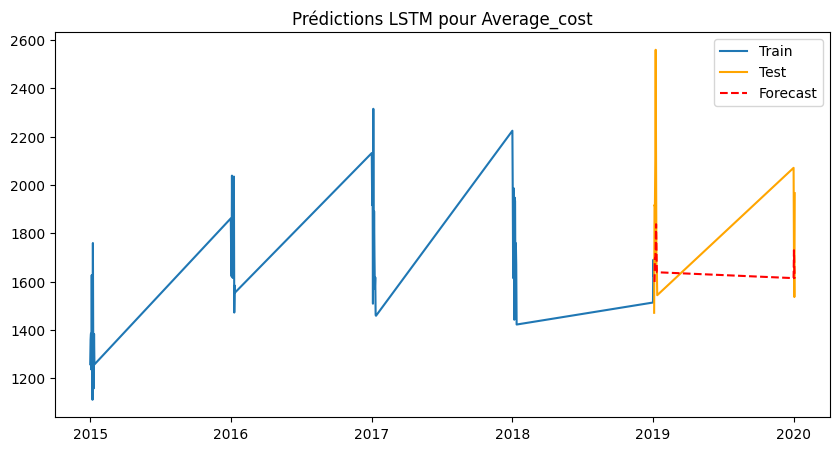

Training LSTM model for The_average_annual_payroll_of_the_region...
Epoch 1/200


C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2837
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3138 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3106 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3220 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2746 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2081 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2209 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2352 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1612 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1655 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1379 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0986 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0882 
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0712 
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0674 
Epoch 16/200
4/4 ━━━━━━━━━━━━━━━

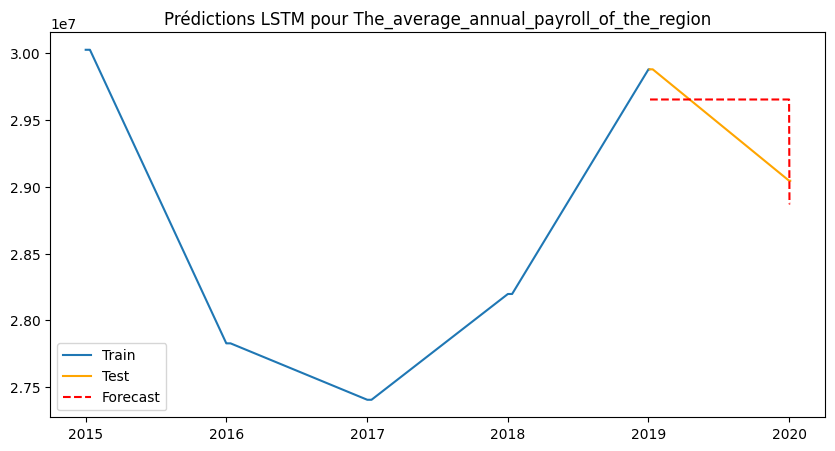

Toutes les prédictions LSTM ont été enregistrées.


In [4]:


# 2. Charger les données
# Charger les données prétraitées
df = pd.read_csv("../datasets/Month_Value_1.csv", parse_dates=True, index_col=0)

# S'assurer que l'index est une colonne de type datetime
df.index = pd.to_datetime(df.index)

df.dropna(inplace=True)

# Identifier les colonnes cibles (toutes sauf la date)
target_columns = df.columns.tolist()

# Dictionnaire pour stocker les prédictions
forecast_results = {}

# 3. Normalisation des données
# LSTM fonctionne mieux avec des données normalisées entre 0 et 1 :
scalers = {}
scaled_data = {}

for column in target_columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data[column] = scaler.fit_transform(df[[column]])
    scalers[column] = scaler

# 4. Transformer les données en séquences pour LSTM
def create_sequences(data, seq_length=12):
    """
    Transforme les données en séquences pour le modèle LSTM.
    Chaque séquence contient seq_length valeurs passées pour prédire la suivante.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

#seq_length: Nombre de pas de temps utilisés pour la prédiction
detected_freq = pd.infer_freq(df.index)
print("***",detected_freq,"***")
if detected_freq in ["D", "B"]:  # Quotidienne ou Business Days
    seq_length = 10
elif detected_freq in ["MS", "M"]:# "justify your choices"
    seq_length = 12
else:
    seq_length = 1
print(seq_length)
# Dictionnaire pour stocker les séquences
sequences = {}

for column in target_columns:
    X, y = create_sequences(scaled_data[column], seq_length)
    sequences[column] = (X, y)

# 5. Séparer les données en Train (80%) et Test (20%)
train_size = int(0.8 * len(df))

train_sequences = {}
test_sequences = {}

for column in target_columns:
    X, y = sequences[column]
    train_sequences[column] = (X[:train_size], y[:train_size])
    test_sequences[column] = (X[train_size:], y[train_size:])

# 6. Définir l'architecture du modèle LSTM
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(200, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(200, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 7. Entraîner un modèle LSTM par colonne
for column in target_columns:
    print(f"Training LSTM model for {column}...")

    X_train, y_train = train_sequences[column]
    X_test, y_test = test_sequences[column]

    # Construire et entraîner le modèle
    model = build_lstm_model((seq_length, 1))
    model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1)

    # Faire des prédictions
    y_pred = model.predict(X_test)

    # Inverser la normalisation
    y_pred_rescaled = scalers[column].inverse_transform(y_pred)
    y_test_rescaled = scalers[column].inverse_transform(y_test)

    # Calculer l'erreur
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    print(f"MSE for {column}: {mse:.4f}")

    # Sauvegarder les résultats
    forecast_results[column] = pd.DataFrame({
        "ds": df.index[train_size + seq_length:],
        "yhat": y_pred_rescaled.flatten()
    })

    # Visualisation
    plt.figure(figsize=(10, 5))
    plt.plot(df.index[:train_size], df[column][:train_size], label="Train")
    plt.plot(df.index[train_size:], df[column][train_size:], label="Test", color="orange")
    plt.plot(df.index[train_size + seq_length:], y_pred_rescaled, label="Forecast", linestyle="dashed", color="red")
    plt.title(f"Prédictions LSTM pour {column}")
    plt.legend()
    plt.show()

# Sauvegarder les prévisions
for col, forecast in forecast_results.items():
    forecast.to_csv(f"forecast_lstm_{col}.csv", index=False)

print("Toutes les prédictions LSTM ont été enregistrées.")